Training started...
Processing dataset: 228_elusage.tsv
{'regression__min_samples': 0.5, 'regression__loss': 'squared_loss', 'regression__stop_probability': 0.25}
R-square score: 0.65


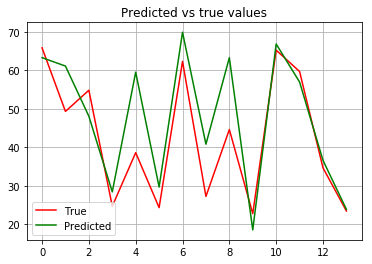

---------------------


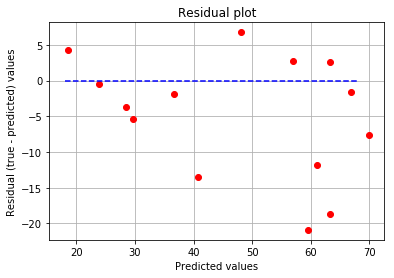

Finished dataset: 228_elusage.tsv
------------------------------------------------------------
Processing dataset: 485_analcatdata_vehicle.tsv
{'regression__min_samples': 0.25, 'regression__loss': 'absolute_loss', 'regression__stop_probability': 0.25}
R-square score: 0.50


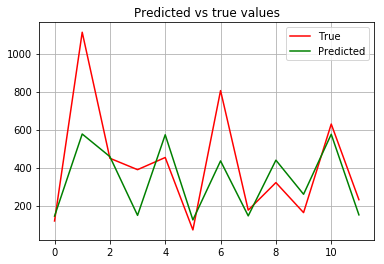

---------------------


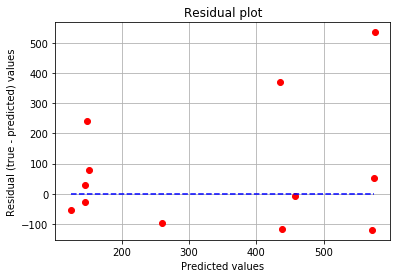

Finished dataset: 485_analcatdata_vehicle.tsv
------------------------------------------------------------
Processing dataset: 523_analcatdata_neavote.tsv
{'regression__min_samples': 0.1, 'regression__loss': 'absolute_loss', 'regression__stop_probability': 0.1}
R-square score: 0.94


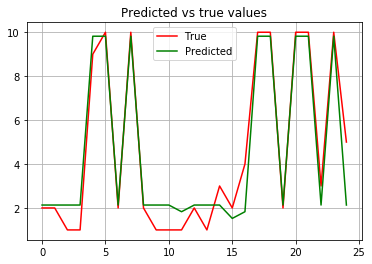

---------------------


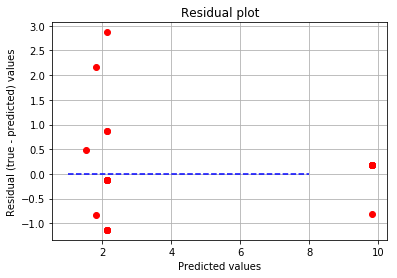

Finished dataset: 523_analcatdata_neavote.tsv
------------------------------------------------------------
Processing dataset: 663_rabe_266.tsv
{'regression__min_samples': 0.25, 'regression__loss': 'absolute_loss', 'regression__stop_probability': 0.1}
R-square score: 0.95


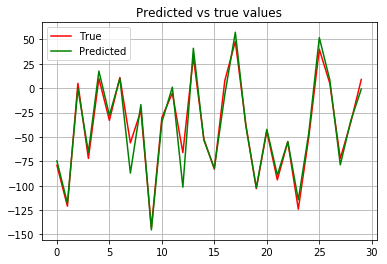

---------------------


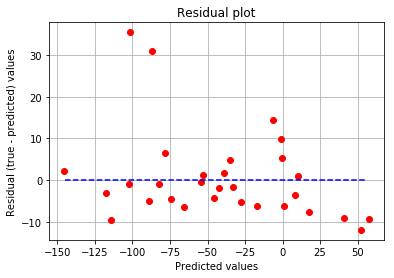

Finished dataset: 663_rabe_266.tsv
------------------------------------------------------------
Processing dataset: 687_sleuth_ex1605.tsv
{'regression__min_samples': 0.25, 'regression__loss': 'squared_loss', 'regression__stop_probability': 0.99}
R-square score: 0.37


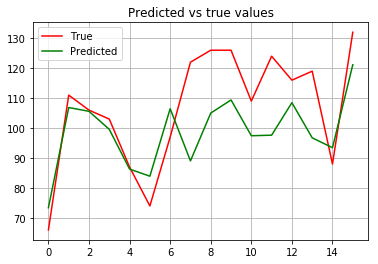

---------------------


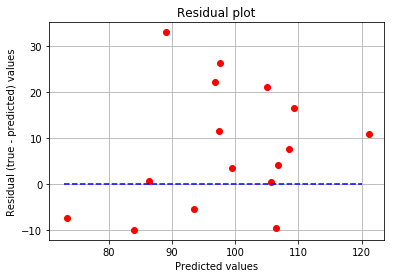

Finished dataset: 687_sleuth_ex1605.tsv
------------------------------------------------------------
Training finished
('Mean R2 square: \n', 0.6811730316250333)
Total time taken: 28 seconds


In [12]:
import sys
import time
import pandas as pd
from sklearn import model_selection
from sklearn import linear_model, metrics, cluster, tree
from matplotlib import pyplot as plt
import scipy
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.feature_selection import *
from sklearn.model_selection import GridSearchCV, KFold

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
start_time = time.time()
datasets = ["228_elusage.tsv", "485_analcatdata_vehicle.tsv", "523_analcatdata_neavote.tsv", \
            '663_rabe_266.tsv', '687_sleuth_ex1605.tsv']

#datasets = ["557_analcatdata_apnea1.tsv", "556_analcatdata_apnea2.tsv"]

regressor = Pipeline([
  #('preprocessing', preprocessing.RobustScaler()),
  #('feature_selection', SelectKBest(f_regression)),
  ('regression', linear_model.RANSACRegressor())
])

ard_parameters = [{ \
    #'feature_selection__k': [1, 2, 3, 4, 'all'], \
    #'regression__base_estimator': [linear_model.LinearRegression(), linear_model.ElasticNet(), tree.ExtraTreeRegressor()], \
    'regression__min_samples': [0.1, 0.25, 0.5, 1.0], \
    'regression__stop_probability': [0.0, 0.1, 0.25, 0.5, 0.99], \
    'regression__loss': ['absolute_loss', 'squared_loss'], \
}]

print('Training started...')
dataset_accuracies = list()
r2_scores = list()
for d_set in datasets:
    print("Processing dataset: %s" % d_set)
    data_path = "data/" + d_set
    df = pd.read_csv(data_path, sep="\t")
    label = df["target"].copy()
    data = df.drop("target", axis=1)
    optimized_regressor = GridSearchCV(regressor, ard_parameters, \
                                       cv=KFold(n_splits=3, shuffle=True, random_state=3111696), \
                                       error_score=0, scoring='r2')
    optimized_regressor.fit(data, label)
    best_regressor = optimized_regressor.best_estimator_
    best_result = optimized_regressor.cv_results_
    print(optimized_regressor.best_params_)
    best_score = optimized_regressor.best_score_
    r2_scores.append(best_score)
    print("Best score: ", best_score)
    print("Finished dataset: %s" % d_set)
    print("------------------------------------------------------------")

print('Training finished')
print("Mean R2 square: \n", np.mean(r2_scores))
end_time = time.time()
print('Total time taken: %d seconds' % int(end_time - start_time))